In [1]:
import os
import shap
import pandas as pd
import torch
from mihm.data.process import multi_cat_to_one_hot, binary_to_one_hot, standardize_continuous_cols
from mihm.data.trainutils import train_test_split
from mihm.model.mihm import ContPM25Model, IndexPredictionModel
from mihm.model.modelutils import get_index_prediction_weights

In [2]:
read_cols = ["zPCPhenoAge_acc", "m_HeatIndex_7d", "age2016", "female", "racethn", "eduy", "ihs_wealthf2016", "pmono", "PNK_pct", 
            "PBcell_pct", "PCD8_Plus_pct", "PCD4_Plus_pct", "PNCD8_Plus_pct", "pm1yr", "pm25_1", "pm25_7", "pm25_30",
            "smoke2016", "drink2016", "bmi2016", "tractdis", "urban", "mar_cat2", "psyche2016", "stroke2016", "hibpe2016",
            "diabe2016", "hearte2016", "ltactx2016", "mdactx2016", "vgactx2016", "chd2016", "dep2016", "adl2016", 
            "living2016", "division"]


df = pd.read_stata('../HeatResilience.dta', columns=read_cols)

In [3]:
categorical_cols = ['female', 'racethn', "smoke2016", 'drink2016', 'urban', 'mar_cat2', "psyche2016", "stroke2016", 
                    "hibpe2016", "diabe2016", "hearte2016", 'ltactx2016', 'mdactx2016', 'vgactx2016', 'living2016', 'division',]
for c in categorical_cols:
    df[c] = df[c].astype("category")
categorical = [c for c in df.columns if df[c].dtype == "category"]
# separate binary vs multicategory cols
binary_cats = [c for c in categorical if df[c].nunique() <=2]
multi_cats = [c for c in categorical if df[c].nunique() > 2]

In [4]:
# convert categorical columns to one-hot
df = binary_to_one_hot(df, binary_cats)
df = multi_cat_to_one_hot(df, multi_cats)

In [5]:
continuous_vars = ['eduy', 'ihs_wealthf2016', 'age2016', 'pmono','bmi2016', 'tractdis', 'chd2016', 'dep2016', 'adl2016', "pm25_7",
                    "PNK_pct", "PBcell_pct", "PCD8_Plus_pct", "PCD4_Plus_pct", "PNCD8_Plus_pct",]
df_norm, mean_std_dict = standardize_continuous_cols(df, continuous_vars)
# drop Nan rows
df_norm.dropna(inplace=True)

In [6]:
input_cols = ['female', 'eduy', 'ihs_wealthf2016', 'pmono', 'bmi2016', "age2016",
            'tractdis', 'mar_cat2', 'psyche2016', 'stroke2016', 'hibpe2016', 
            'diabe2016', 'hearte2016', 'chd2016', 'dep2016', 'adl2016', 'living2016', 
            'racethn_0. NHW', 'racethn_1. NHB', 'racethn_2. Hispanic', 'racethn_3. Others', 
            'smoke2016_0.0', 'smoke2016_1.0', 'smoke2016_2.0', 
            'drink2016_0. non-current drinker', 'drink2016_1. light drinker', 'drink2016_2. heavy drinker, >=7 days a week', 
            'urban_1. urban', 'urban_2. suurban (code 2)', 'urban_3. ex-urban', 
            'ltactx2016_0. never', 'ltactx2016_1. 1-3 per month', 'ltactx2016_2. 1 per week', 'ltactx2016_3. >1 per week', 'ltactx2016_4. every day',
            'mdactx2016_0. never', 'mdactx2016_1. 1-3 per month', 'mdactx2016_2. 1 per week', 'mdactx2016_3. >1 per week', 'mdactx2016_4. every day', 
            'vgactx2016_0. never', 'vgactx2016_1. 1-3 per month', 'vgactx2016_2. 1 per week', 'vgactx2016_3. >1 per week', 'vgactx2016_4. every day',
            'division_Northeast', 'division_Midwest', 'division_South', 'division_West',
            "PNK_pct", "PBcell_pct", "PCD8_Plus_pct", "PCD4_Plus_pct", "PNCD8_Plus_pct",]
controlled_cols = [
    "pm25_7",
    "pmono",
    "PNK_pct",
    "PBcell_pct",
    "PCD8_Plus_pct",
    "PCD4_Plus_pct",
    "PNCD8_Plus_pct",
]
interaction_predictors = [
    "female", "racethn_0. NHW", "racethn_1. NHB", "racethn_2. Hispanic", "racethn_3. Others",
    'eduy', 'ihs_wealthf2016', 'bmi2016', 
    'tractdis', 'mar_cat2', 'psyche2016', 'stroke2016', 'hibpe2016', 
    'diabe2016', 'hearte2016', 'chd2016', 'dep2016', 'adl2016', 'living2016', 
    'smoke2016_0.0', 'smoke2016_1.0', 'smoke2016_2.0', 
    'drink2016_0. non-current drinker', 'drink2016_1. light drinker', 'drink2016_2. heavy drinker, >=7 days a week', 
    'urban_1. urban', 'urban_2. suurban (code 2)', 'urban_3. ex-urban', 
    'ltactx2016_0. never', 'ltactx2016_1. 1-3 per month', 'ltactx2016_2. 1 per week', 'ltactx2016_3. >1 per week', 'ltactx2016_4. every day',
    'mdactx2016_0. never', 'mdactx2016_1. 1-3 per month', 'mdactx2016_2. 1 per week', 'mdactx2016_3. >1 per week', 'mdactx2016_4. every day', 
    'vgactx2016_0. never', 'vgactx2016_1. 1-3 per month', 'vgactx2016_2. 1 per week', 'vgactx2016_3. >1 per week', 'vgactx2016_4. every day',
    'division_Northeast', 'division_Midwest', 'division_South', 'division_West',
]

In [7]:
# interactor
pm25_cont_np = df_norm["pm25_7"].to_numpy()
# controlled vars
controlled_vars_np = df_norm[controlled_cols].to_numpy()
# interaction input vars
interaction_vars_np = df_norm[interaction_predictors].to_numpy()
# dependent var (label)
pheno_epi_np = df_norm["zPCPhenoAge_acc"].to_numpy()

In [8]:
num_elems, _ = controlled_vars_np.shape
print("number of data points: {}".format(num_elems))

number of data points: 3316


## Load model and predict

In [9]:
input_size = interaction_vars_np.shape[1]
controlled_var_size = controlled_vars_np.shape[1]
hidden_layer_sizes = [100, 50, 1]
model = IndexPredictionModel(input_size, hidden_layer_sizes)

In [10]:
state_dict = torch.load('../checkpoints/Feb2_2024_pm25_model_control_all.ckpt')
state_dict = get_index_prediction_weights(state_dict)
model.load_state_dict(state_dict)
model.cuda().eval()

IndexPredictionModel(
  (layer1): Linear(in_features=47, out_features=100, bias=True)
  (layer2): Linear(in_features=100, out_features=50, bias=True)
  (layer3): Linear(in_features=50, out_features=1, bias=True)
)

In [11]:
interaction_vars_torch = torch.from_numpy(interaction_vars_np.astype('float32')).cuda()
explainer = shap.DeepExplainer(model, interaction_vars_torch)

In [12]:
shap_values = explainer.shap_values(interaction_vars_torch, check_additivity=False)

In [23]:
# save shap values
import numpy as np
np.save("shap_values_pm25.npy", shap_values)

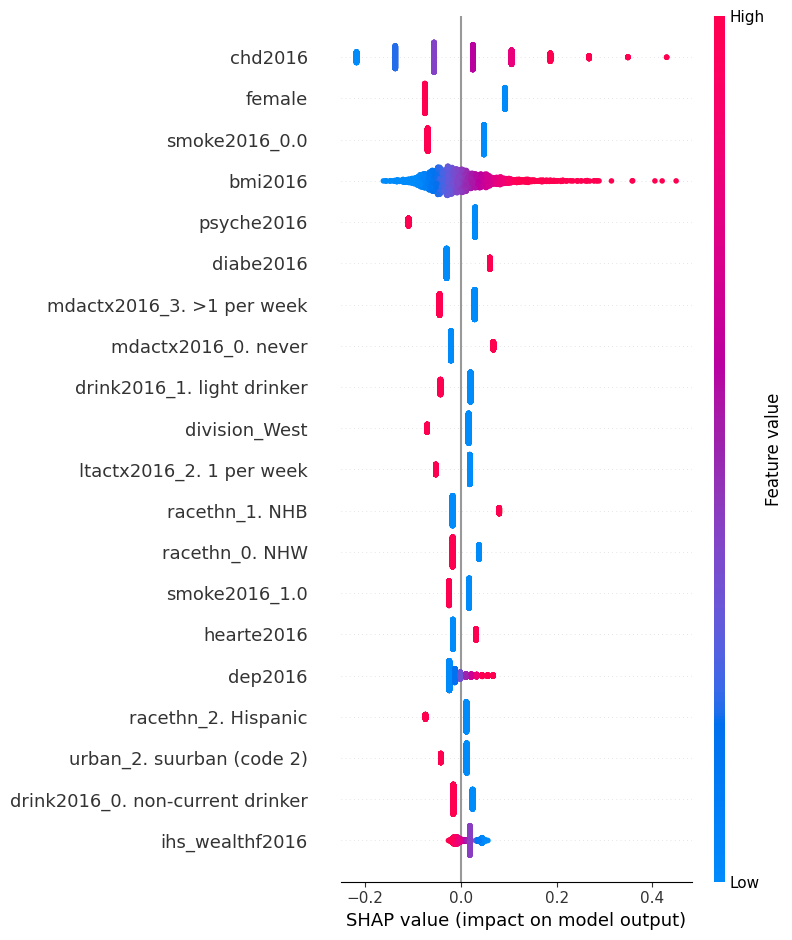

In [15]:
shap.initjs()
shap.summary_plot(shap_values[:, :], interaction_vars_torch[:, :].detach().cpu().numpy(), feature_names=interaction_predictors)

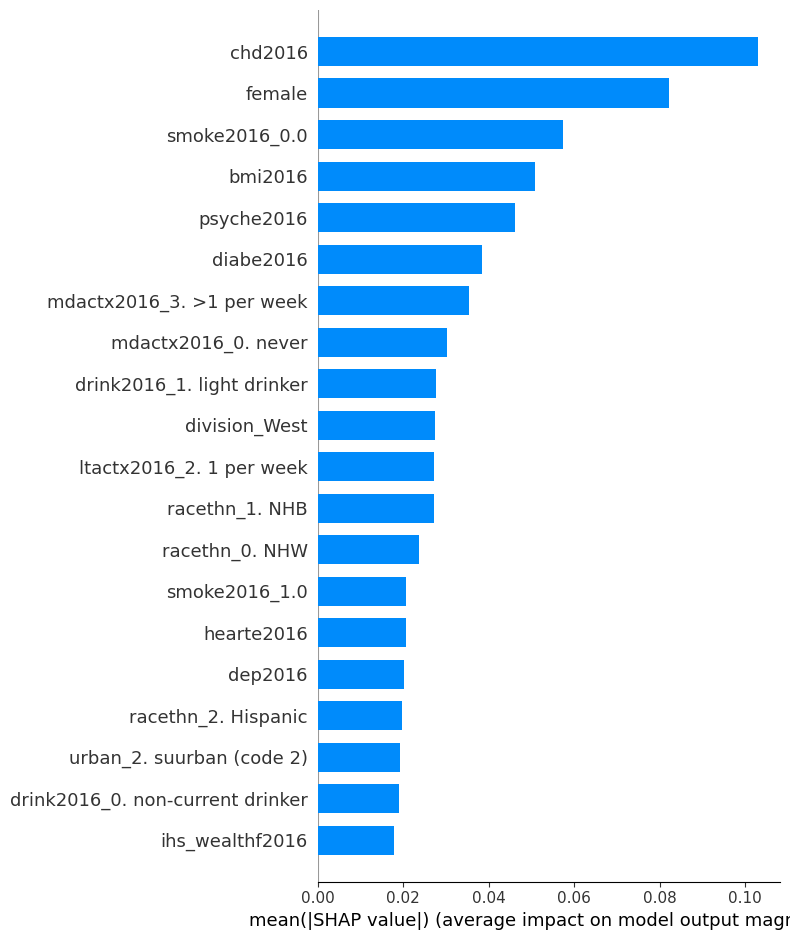

In [24]:
shap.summary_plot(shap_values[:, :], interaction_vars_torch[:, :].detach().cpu().numpy(), feature_names=interaction_predictors, plot_type="bar")